In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"


%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']


Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  200000 

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'cartbox', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'boxcox', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 9.094947017729282e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(160000, 6, 5) (160000, 6) (160000, 9)
(40000, 6, 5) (40000, 6) (40000, 9)


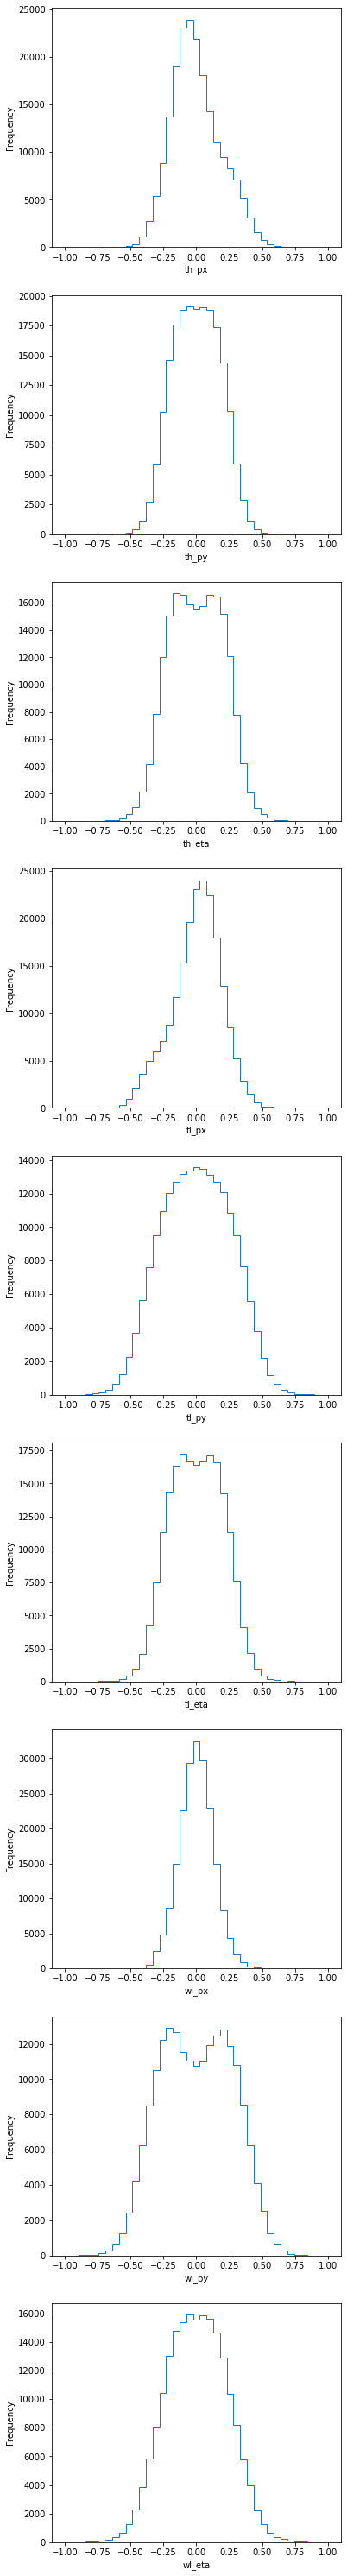

In [4]:
# Histograms of total  Y variables 
show = True

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

# Reweight events to be flat in some area 

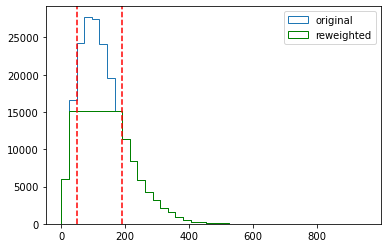

In [6]:
th_pt = np.array(dataset.get('th_pt'))[0:crop0]
hist1, bins = np.histogram(th_pt, 40)
hist1 = hist1 + (hist1<=0)*1
bins[-1] = np.inf
plt.hist(th_pt, 40, histtype='step', label='original')
argright = 8
argleft = 2
right = bins[argright]
left = bins[argleft]
compare_min = hist1[argright-1]
plt.axvline(x=left, color='r', linestyle='--')
plt.axvline(x=right, color='r', linestyle='--')
flat = 1
belong = np.digitize(th_pt, bins) - 1
factor = compare_min/hist1*(hist1>=compare_min) + (hist1<compare_min)
weight = factor[belong]
plt.hist(th_pt, bins, histtype='step', label='reweighted', color='g', weights=weight)
plt.legend()

In [7]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    LSTM11 = LSTM(224, return_sequences=True)(Mask)
    LSTM12 = LSTM(224, return_sequences=True)(LSTM11)
    flat_jets = Flatten()(LSTM12)
    
    other_input = Input(shape=(trainX_other.shape[1]))
    Dense21 = Dense(224, activation='relu')(other_input)
    flat_other = Flatten()(Dense21)
    
    concat = concatenate([flat_other, flat_jets])
    dense1 = Dense(224, activation='relu')(concat)
    dense2 = Dense(224, activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model

# def build_model():
#     jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
#     Mask = Masking(-2)(jet_input)
#     Conv11 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(Mask)
#     Conv12 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(Conv11)
#     flat_jets = Flatten()(Conv11)
    
#     other_input = Input(shape=(trainX_other.shape[1]))
#     Dense21 = Dense(64, activation='relu')(other_input)
#     Dense22 = Dense(32, activation='relu')(Dense21)
#     flat_other = Flatten()(Dense21)
    
#     concat = concatenate([flat_other, flat_jets])
#     dense1 = Dense(256, activation='relu')(concat)
#     dense2 = Dense(128, activation='relu')(dense1)
#     output = Dense(len(Y_names), activation='linear')(dense2)
    
#     model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
#     optimizer = keras.optimizers.Adam(learning_rate=5e-5)
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 6, 5)         0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 224)       206080      masking[0][0]                    
______________________________________________________________________________________________

In [8]:
# Fit model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Epochs= 512

del X_total
del Y_total

history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback], sample_weight=weight[0:split],
                   batch_size=512)

Train on 128000 samples, validate on 32000 samples
Epoch 1/512
128000/128000 [==============================] - 17s 133us/sample - loss: 0.0218 - mse: 0.0282 - val_loss: 0.0154 - val_mse: 0.0201
Epoch 2/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0147 - mse: 0.0193 - val_loss: 0.0143 - val_mse: 0.0188
Epoch 3/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0139 - mse: 0.0183 - val_loss: 0.0137 - val_mse: 0.0180
Epoch 4/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0135 - mse: 0.0177 - val_loss: 0.0133 - val_mse: 0.0175
Epoch 5/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0131 - mse: 0.0173 - val_loss: 0.0129 - val_mse: 0.0171
Epoch 6/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0127 - mse: 0.0168 - val_loss: 0.0125 - val_mse: 0.0166
Epoch 7/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0123 - ms

Epoch 58/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0095 - mse: 0.0128 - val_loss: 0.0097 - val_mse: 0.0131
Epoch 59/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0095 - mse: 0.0128 - val_loss: 0.0097 - val_mse: 0.0131
Epoch 60/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0094 - mse: 0.0128 - val_loss: 0.0097 - val_mse: 0.0131
Epoch 61/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0094 - mse: 0.0128 - val_loss: 0.0096 - val_mse: 0.0130
Epoch 62/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0094 - mse: 0.0128 - val_loss: 0.0096 - val_mse: 0.0130
Epoch 63/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0094 - mse: 0.0127 - val_loss: 0.0096 - val_mse: 0.0130
Epoch 64/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0094 - mse: 0.0127 - val_loss: 0.0096 - val_mse: 0.0130

128000/128000 [==============================] - 5s 43us/sample - loss: 0.0088 - mse: 0.0120 - val_loss: 0.0092 - val_mse: 0.0125
Epoch 116/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0088 - mse: 0.0120 - val_loss: 0.0092 - val_mse: 0.0125
Epoch 117/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0088 - mse: 0.0120 - val_loss: 0.0092 - val_mse: 0.0125
Epoch 118/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0088 - mse: 0.0119 - val_loss: 0.0092 - val_mse: 0.0125
Epoch 119/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0088 - mse: 0.0119 - val_loss: 0.0092 - val_mse: 0.0124
Epoch 120/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0088 - mse: 0.0119 - val_loss: 0.0092 - val_mse: 0.0124
Epoch 121/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0087 - mse: 0.0119 - val_loss: 0.0092 - val_mse: 0.0124
Epoch 

Epoch 172/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0084 - mse: 0.0114 - val_loss: 0.0090 - val_mse: 0.0122
Epoch 173/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0083 - mse: 0.0114 - val_loss: 0.0090 - val_mse: 0.0122
Epoch 174/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0083 - mse: 0.0114 - val_loss: 0.0090 - val_mse: 0.0122
Epoch 175/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0083 - mse: 0.0114 - val_loss: 0.0090 - val_mse: 0.0122
Epoch 176/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0083 - mse: 0.0114 - val_loss: 0.0090 - val_mse: 0.0122
Epoch 177/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0083 - mse: 0.0114 - val_loss: 0.0090 - val_mse: 0.0122
Epoch 178/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0083 - mse: 0.0114 - val_loss: 0.0090 - val_mse:

Epoch 229/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0080 - mse: 0.0110 - val_loss: 0.0089 - val_mse: 0.0121
Epoch 230/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0080 - mse: 0.0110 - val_loss: 0.0089 - val_mse: 0.0121
Epoch 231/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0080 - mse: 0.0110 - val_loss: 0.0089 - val_mse: 0.0121
Epoch 232/512
128000/128000 [==============================] - 5s 43us/sample - loss: 0.0080 - mse: 0.0110 - val_loss: 0.0089 - val_mse: 0.0121
Epoch 233/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0080 - mse: 0.0110 - val_loss: 0.0089 - val_mse: 0.0121
Epoch 234/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0080 - mse: 0.0110 - val_loss: 0.0089 - val_mse: 0.0121
Epoch 235/512
128000/128000 [==============================] - 5s 42us/sample - loss: 0.0080 - mse: 0.0109 - val_loss: 0.0089 - val_mse:

Text(0.5, 1.0, 'MSE loss')

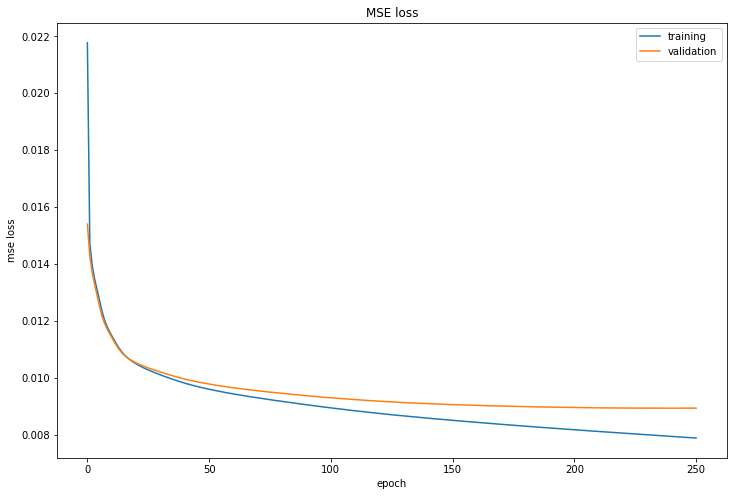

In [9]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [10]:
class Analysis:
    def __init__(self):
        self.crop = 100
        self.fsize = 6
        self.histogram_bins = 40
        
    def wrap_phi(self, var):
        var = var%(2*np.pi)
        var = var - 2*np.pi*(var > np.pi)
        return var
        
    def predictions_vs_sample(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2, self.fsize*len(names)))
        for i in range(0, len(names)):
            compare_small = compare[:self.crop,i]
            true_small = true[:self.crop,i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            plt.subplot(len(names), 1, i+1)
            plt.plot(range(0,self.crop), compare_small, 'bo', markersize=3, label = 'Predictions')
            plt.plot(range(0,self.crop), true_small, 'ro', markersize=3, label = 'True Value')
            ym, yM = plt.ylim()
            for x in range(self.crop):
                plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                            min(compare_small[x], true_small[x]), 
                            ymax= max(compare_small[x], true_small[x]))
            plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=self.crop+20, alpha=0.5)
            MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
            plt.xlabel('Sample')
            plt.xlim(0, self.crop)
            plt.ylabel(names[i])
            plt.title(names[i] + " MSE: " + str(MSE))
            plt.legend()
    
    def display_errors(self, compare, true, names, wrap_phi):
        MSE = 1/compare.size*np.sum((compare- true)**2)
        print("total MSE: " + str(MSE))
        print(" ")
        for i in range(len(names)):
            diff = compare[:,i] -true[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            MSE = 1/compare[:,i].size*np.sum((diff)**2)
            print("{0} MSE : ".format(names[i]), '%.10f'%MSE)
    
    def difference_histogram(self, compare, true, names, wrap_phi, bins):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            diff = true[:,i] - compare[:,i]
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
            plt.hist(diff, hbins, histtype='step', color='purple', label='true - predicted', density=True)
            plt.xlabel("Difference (Mean: {0}, Std: {1})".format(np.mean(diff), np.std(diff)))
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
            
    def variable_histogram(self, compare, true, names, wrap_phi, bins): 
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            compare_small = compare[:, i]
            true_small = true[:, i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
                
            plt.hist(true_small, hbins, histtype='step', color='b', label='true values', density=False)
            plt.hist(compare_small, hbins, histtype='step', color='r', label='predictions', density=False)
            plt.xlabel(names[i])
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
    
    def difference_vs_variable(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], true[:, i]-compare[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
            plt.xlabel('True ' + names[i])
            plt.legend()
            plt.ylabel('Difference')
    
    def predicted_vs_true(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], compare[:, i], 'o', color='g', markersize=2)
            line = np.linspace(np.min(true[:, i]), np.max(true[:, i]), 100)
            plt.plot(line, line, color='b')
            plt.xlabel('True')
            plt.title(names[i])
            plt.ylabel('Predicted')

In [11]:
display = Analysis()

predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

# Training scale plots 

In [12]:
display.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.012179781900192544
 
th_px MSE :  0.0139296283
th_py MSE :  0.0155361010
th_eta MSE :  0.0097808306
tl_px MSE :  0.0097083787
tl_py MSE :  0.0256313669
tl_eta MSE :  0.0071783288
wl_px MSE :  0.0024760813
wl_py MSE :  0.0170071692
wl_eta MSE :  0.0083701523


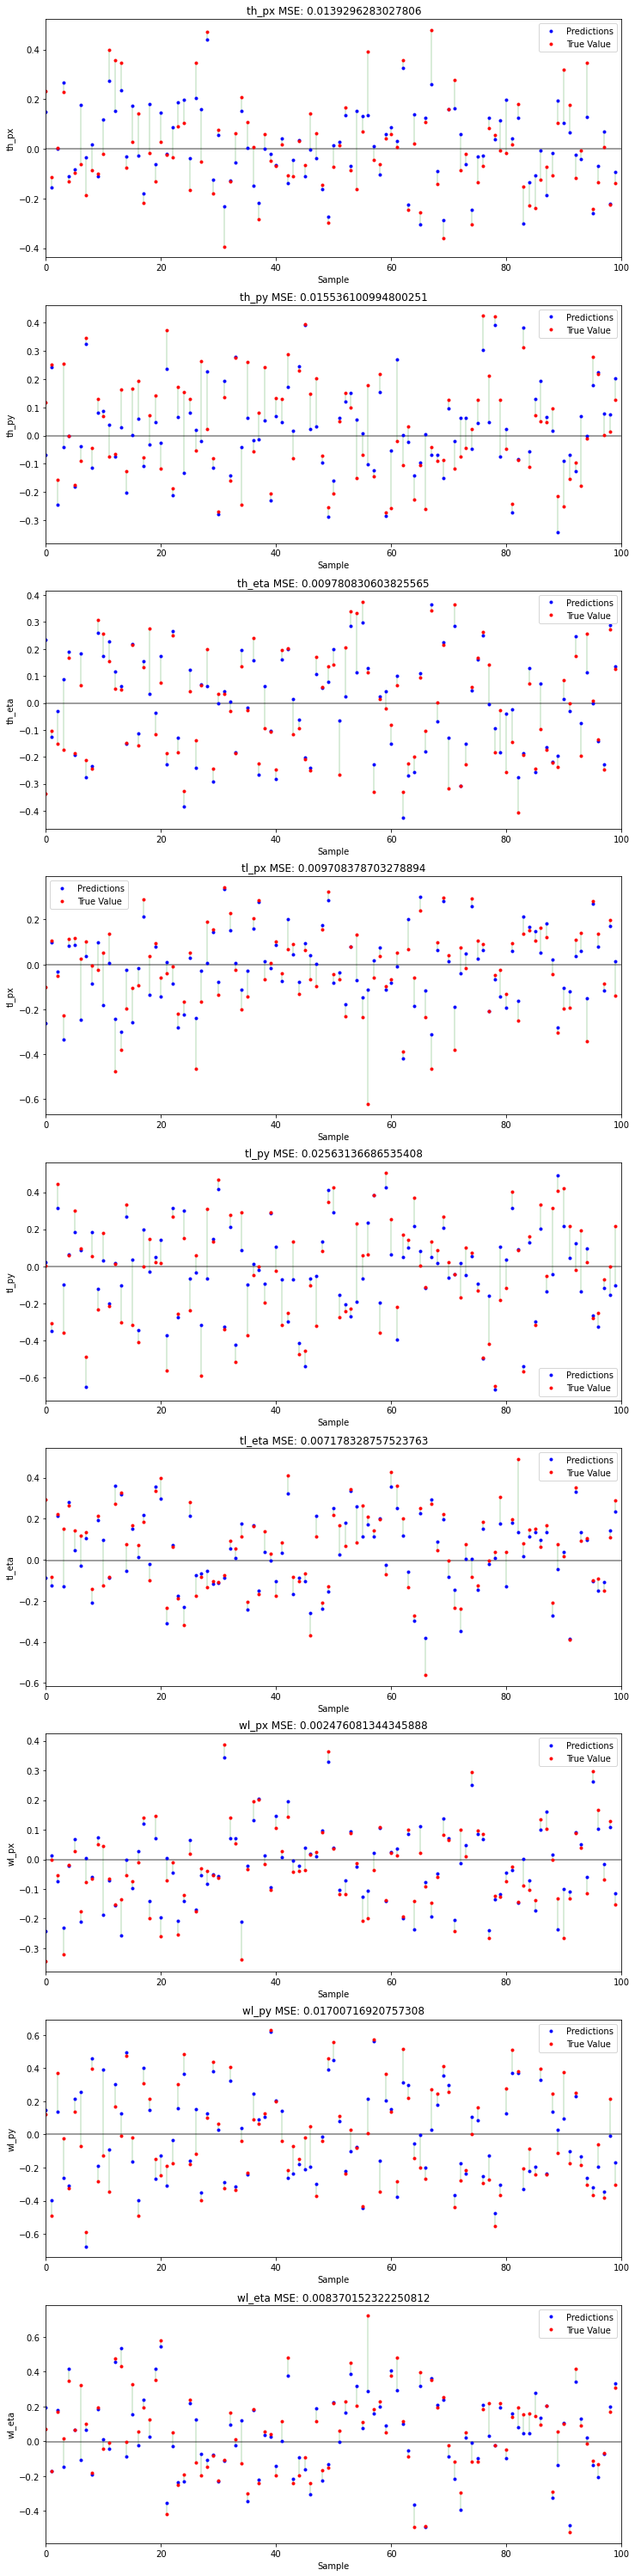

In [13]:
display.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

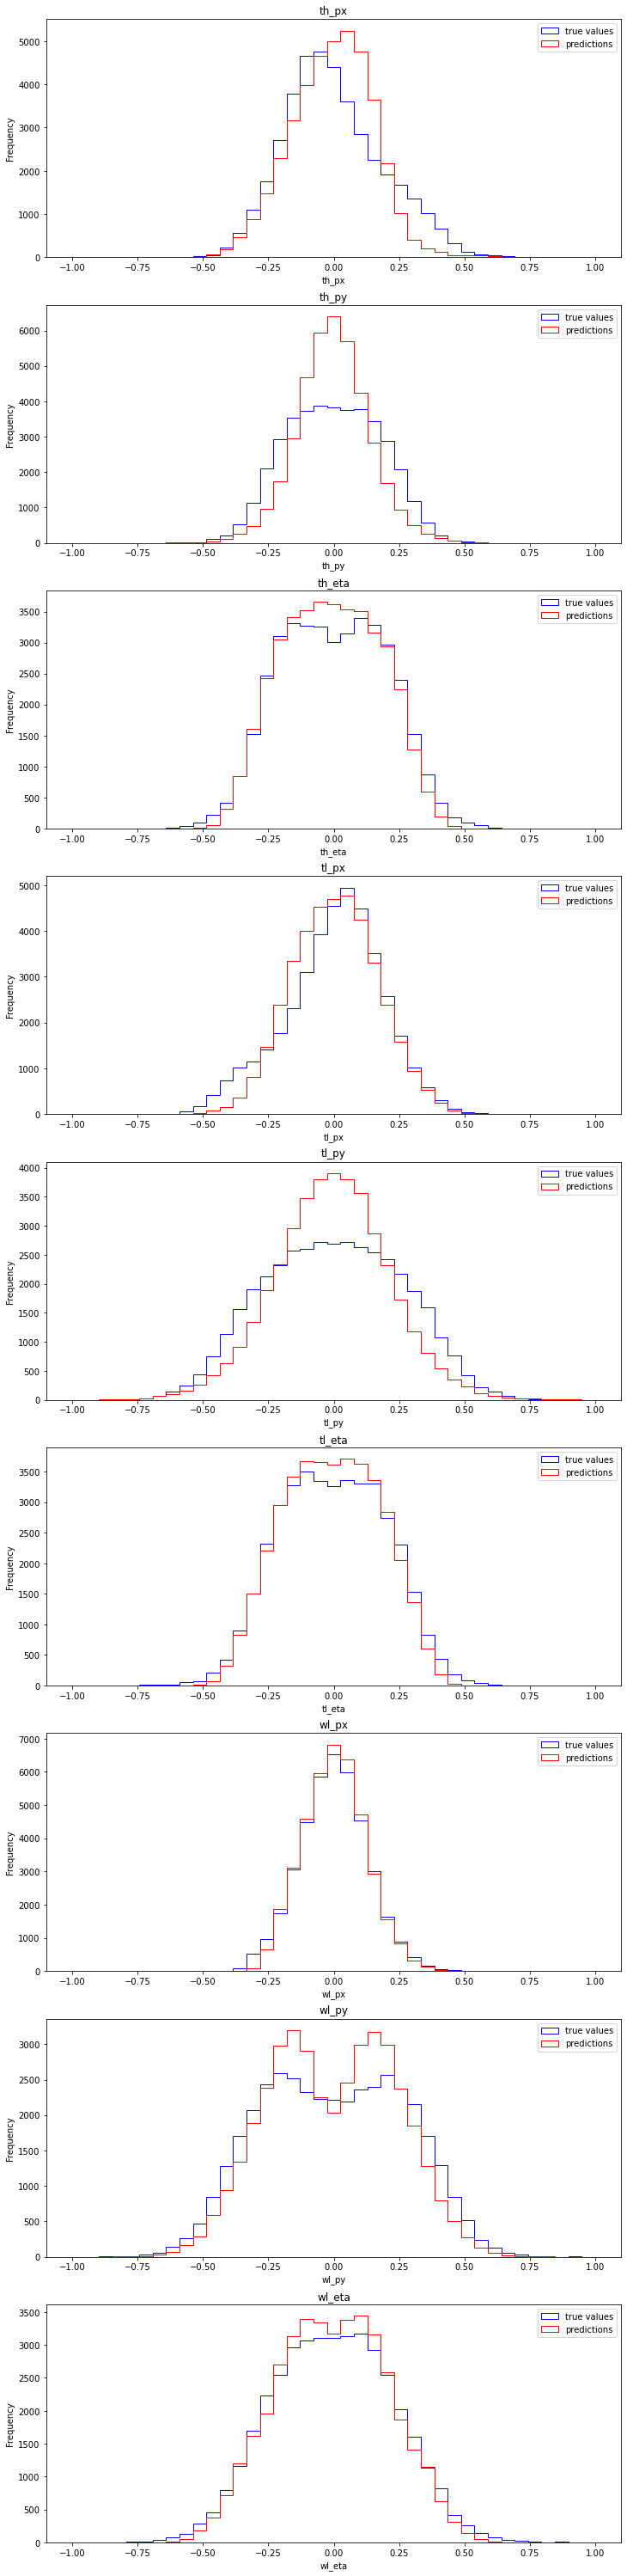

In [14]:
display.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

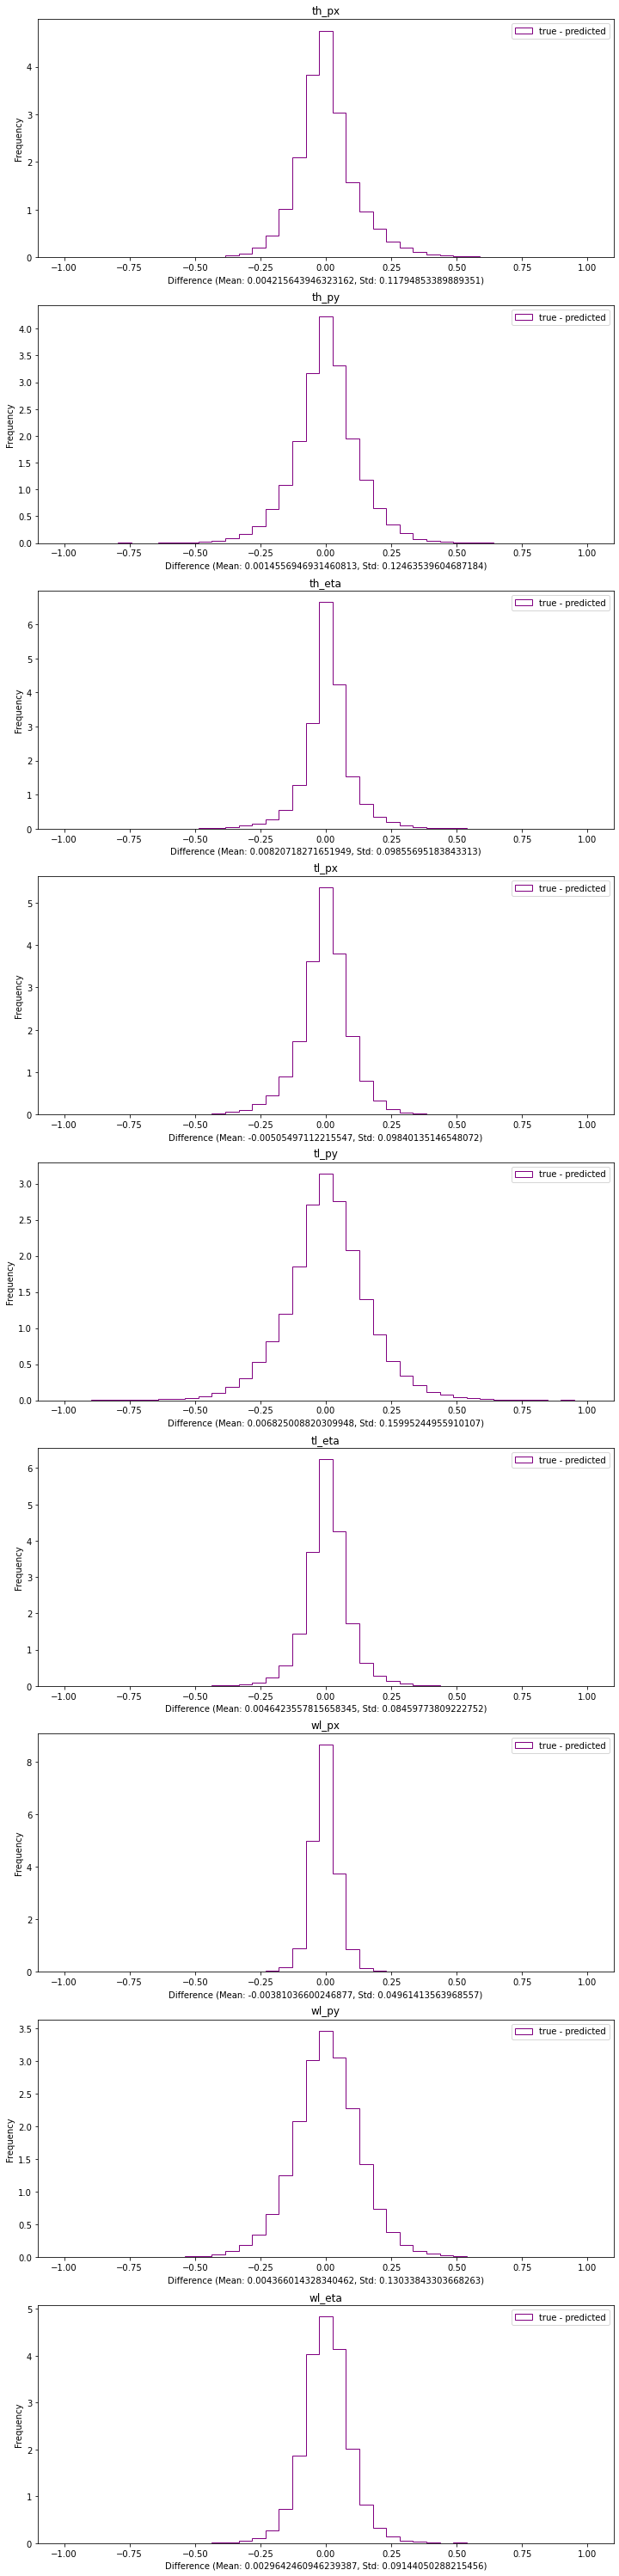

In [15]:
display.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

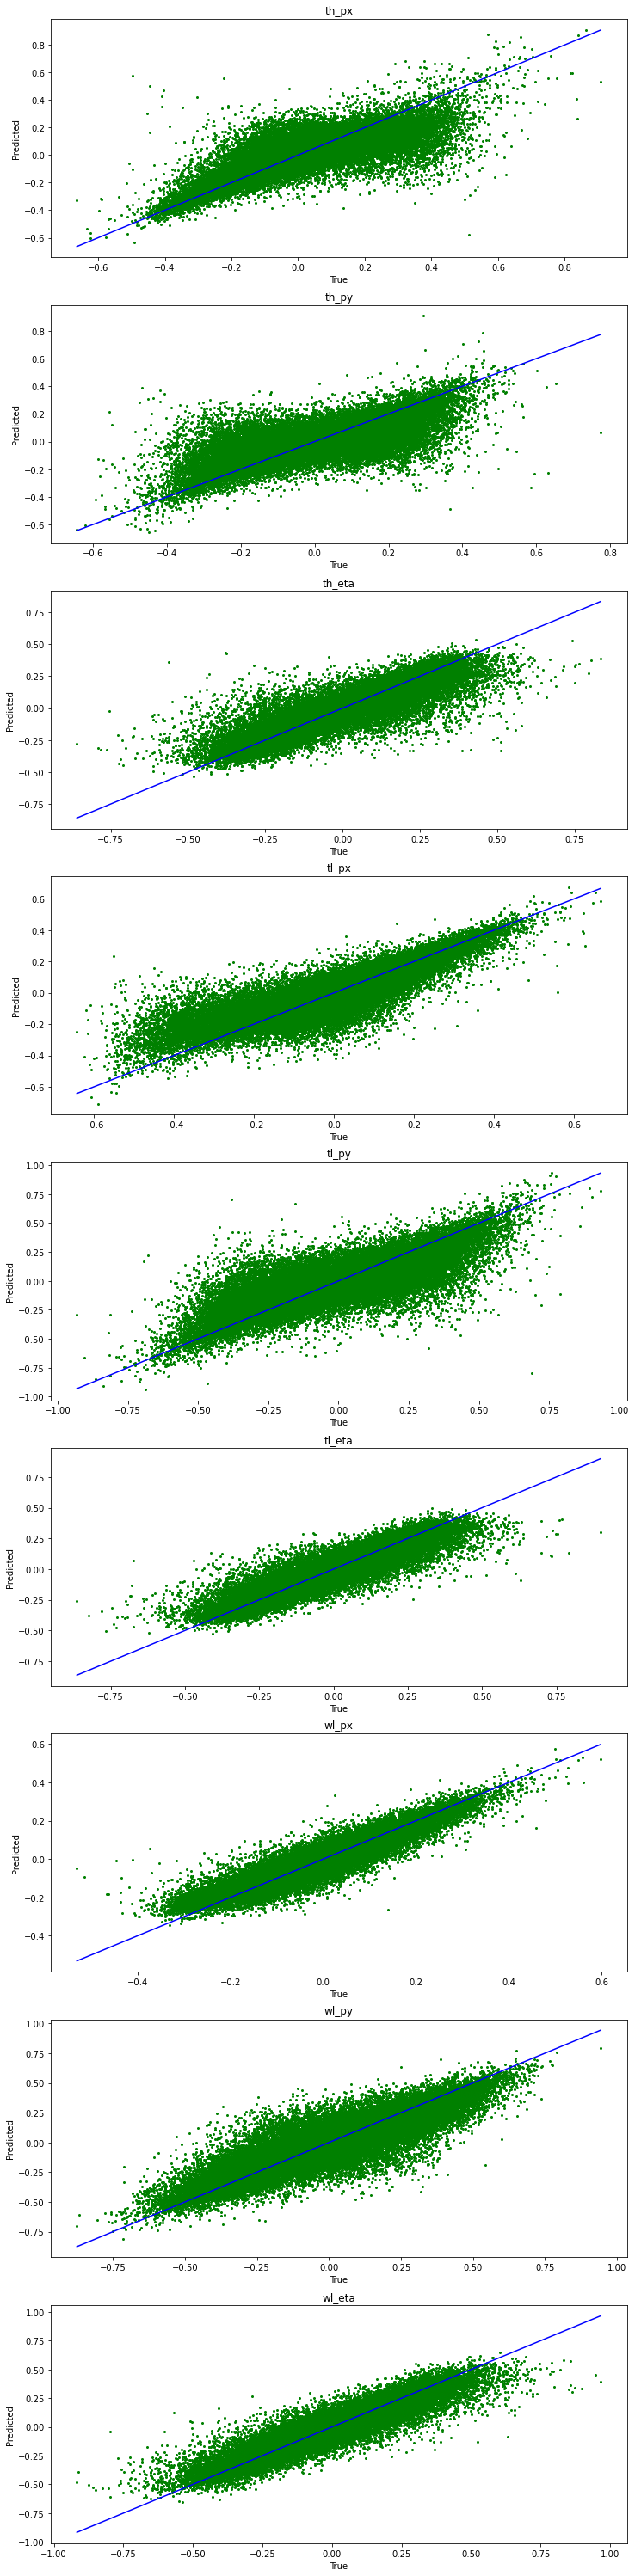

In [16]:
display.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [17]:
display.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 712.4334379899636
 
th_pt MSE :  3645.2140591694
th_eta MSE :  0.5796305725
th_phi MSE :  0.8507088994
tl_pt MSE :  2104.8523911812
tl_eta MSE :  0.4258355403
tl_phi MSE :  0.5323669238
wl_pt MSE :  654.1825978803
wl_eta MSE :  0.2995130226
wl_phi MSE :  0.1845617983


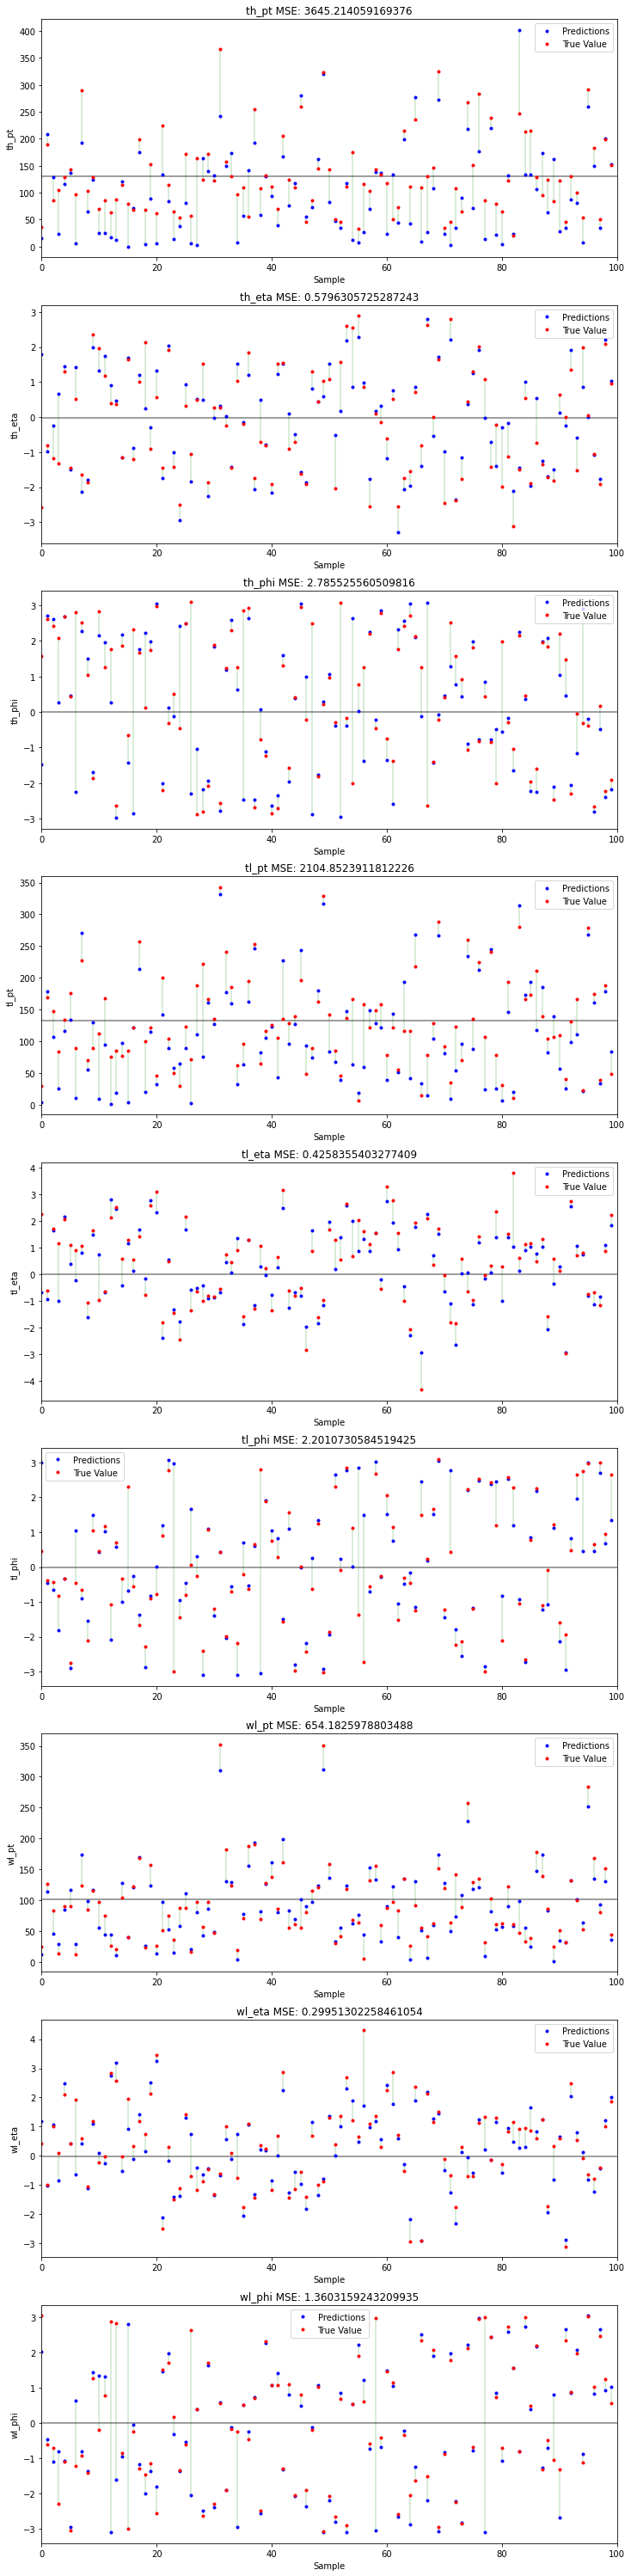

In [18]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

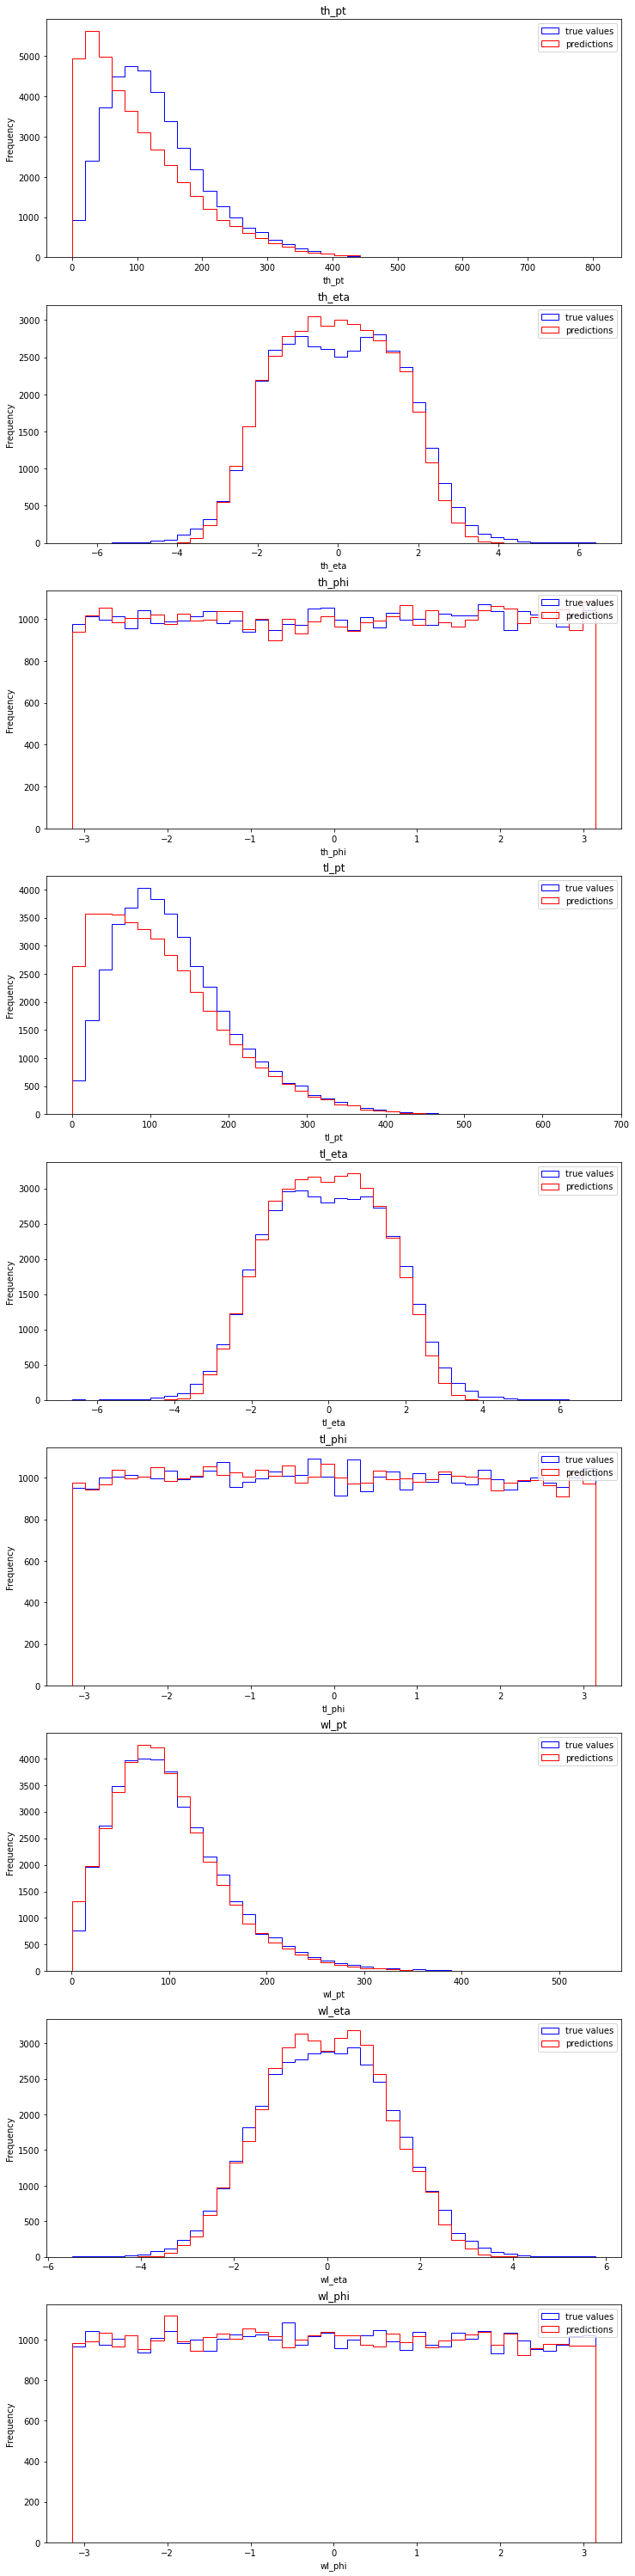

In [19]:
display.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

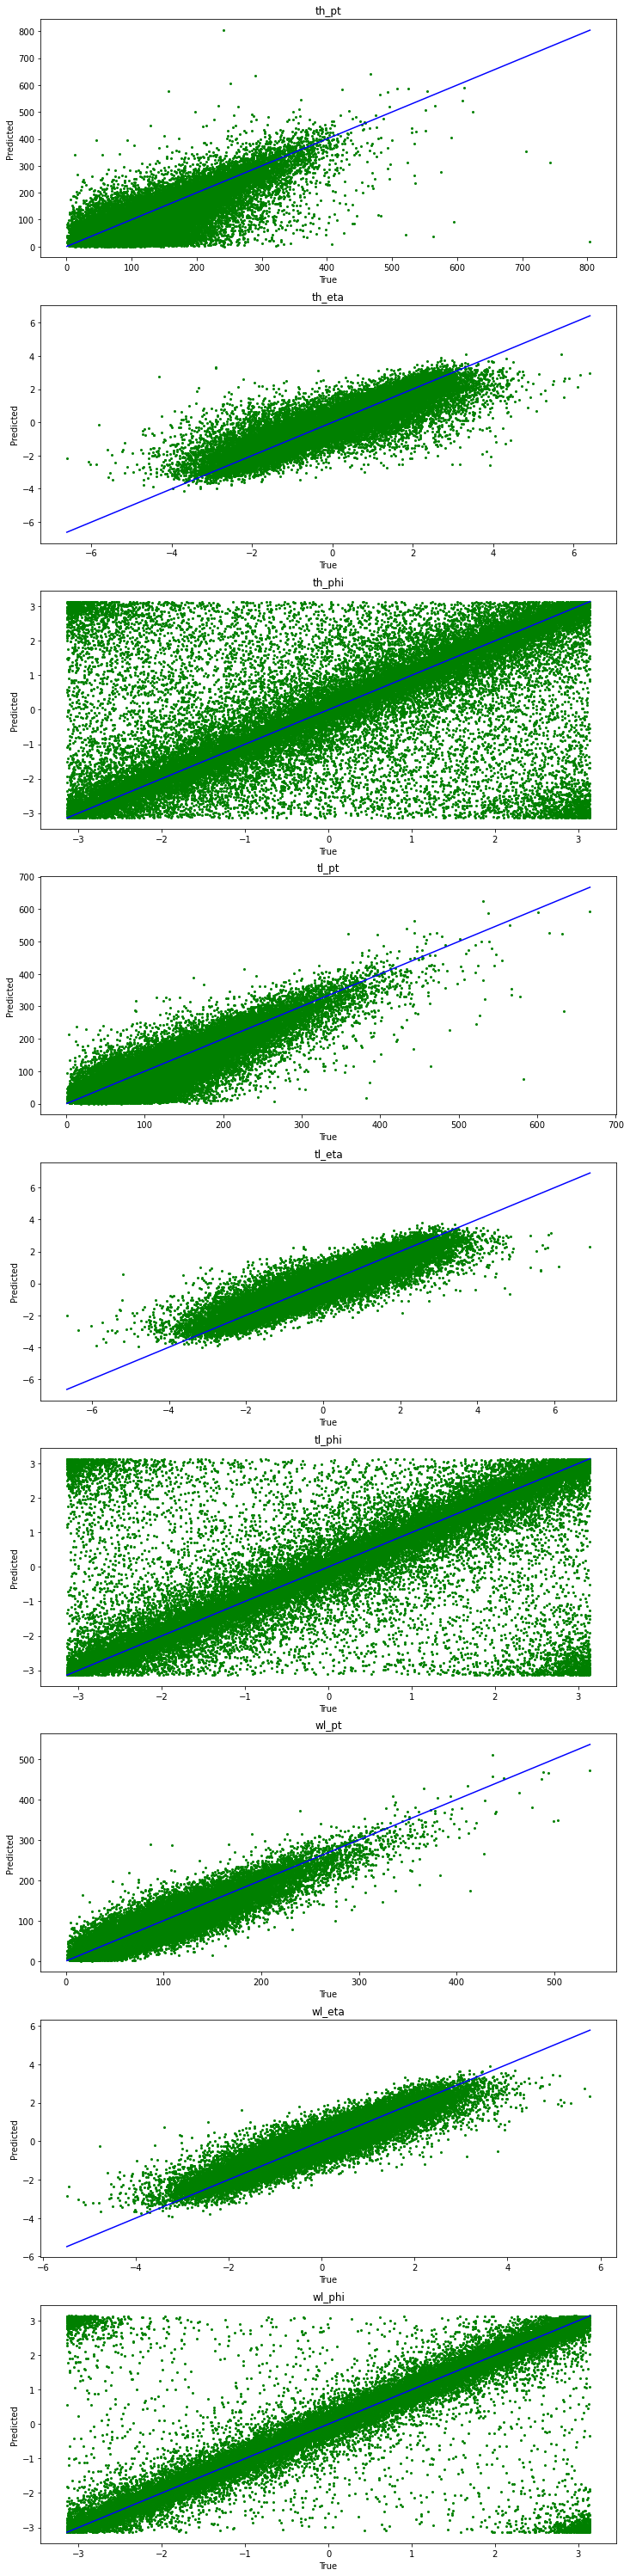

In [20]:
display.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)